In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import random 
from datetime import datetime
import pandas as pd
import os 

import sys
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/utils/')
# sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/utils/')
from exp_hp import get_hp
from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results, adjust_spines
from dataprep_utils import get_testing
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/interpret/')
# sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/interpret/')
from Gordon_interp import getoutputvecs, confvacc, iconfcorr


# import importlib
# importlib.reload(sys.modules["Gordon_interp"])
# from Gordon_interp import getoutputvecs, confvacc, iconfcorr
# importlib.reload(sys.modules["trainGordon_utils"])
# from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

2023-12-14 09:54:35.386210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 09:54:35.618044: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 09:54:35.623908: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/23.10/spack/opt/spack/openmpi/4.1.6/oneapi/2023.2.1/dgcv/lib:/glade/u/apps/

## Functions

In [33]:
def days_in_year(Ytrain):
    _DAYS_IN_MONTH = [31,28,31,30,31,30,31,31,30,31,30,31]  # Ignores leap days.
    start_year, end_year = int(Ytrain.time.dt.year[0]), int(Ytrain.time.dt.year[-1])+1
    dates = []
    for year in range(start_year, end_year):
        for month in range(1, 13):
            for day in range(1, _DAYS_IN_MONTH[month-1]+1):
                dates.append(datetime(year, month, day, hour=0, minute=0))
                
    dates = pd.to_datetime(dates)
    dates_a2a = dates[119:(36500+119)]
    return dates,dates_a2a

In [5]:
MODEL_DIR = '/glade/work/kjmayer/research/catalyst/ENSOvsMJO/data/doy_models/' #models/'
# MODEL_DIR = '/glade/scratch/wchapman/ENSOmjo_ML_models/saved_models/'
EXP_NAME = 'default'
hps = get_hp(EXP_NAME)
# variables:
DROPOUT_RATE = hps['DROPOUT_RATE']

MODELNAME1 = 'ENSO'
RIDGE1 = hps['RIDGE1']
HIDDENS1 = hps['HIDDENS1']

MODELNAME2 = 'MJO'
RIDGE2 = hps['RIDGE2']
HIDDENS2 = hps['HIDDENS2']

BATCH_SIZE = hps['BATCH_SIZE']
N_EPOCHS = 10000
PATIENCE = hps['PATIENCE'] # number of epochs of no "improvement" before training is stopped
LR = hps['LR'] # learning rate


LEADS = np.arange(5,6)#,31)
AVGS = np.arange(2,3)#,29) #32)
SEEDS = np.arange(1,2)#,6)

SAVE = False

In [10]:
# model raw predictions
# confidence vs accuracy
# model contribution fractions

for l in LEADS:
    print('LEAD: '+str(l)) #+'\nAVG: '+str(a))
    for a in AVGS:
        #check if files already exist:
        ddir_save = '/glade/derecho/scratch/kjmayer/DATA/ENSOvsMJO/data/doy_interpret/'
        finame_confvsacc = 'confvsacc_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
        if os.path.isfile(ddir_save+finame_confvsacc):
            # print('load testing data')
            X1test, X2test, Ytest = get_testing(N_z500runmean=a,
                                                LEAD=l)

            INPUT_SHAPE1 = np.shape(X1test)[1:][0]
            INPUT_SHAPE2 = np.shape(X2test)[1:][0]
            
            confvsacc = np.zeros(shape=(len(SEEDS),100))

            model1_rawpreds = np.zeros(shape=(len(SEEDS),np.shape(X1test)[0],2))
            model2_rawpreds = np.zeros(shape=(len(SEEDS),np.shape(X1test)[0],2))
            model_rawpreds = np.zeros(shape=(len(SEEDS),np.shape(X1test)[0],2))
            
            model1_all_fracpred = np.zeros(shape=(len(SEEDS)))
            model2_all_fracpred = np.zeros(shape=(len(SEEDS)))
            model12_all_fracpred = np.zeros(shape=(len(SEEDS)))
            
            model1_allcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            model2_allcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            model12_allcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            
            model1_conf_fracpred = np.zeros(shape=(len(SEEDS)))
            model2_conf_fracpred = np.zeros(shape=(len(SEEDS)))
            model12_conf_fracpred = np.zeros(shape=(len(SEEDS)))
            
            model1_confcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            model2_confcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            model12_confcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            
            
            for s in SEEDS:
                # ENSO MODEL
                model1, input1 = build_model(s,
                                             DROPOUT_RATE,
                                             RIDGE1,
                                             HIDDENS1,
                                             INPUT_SHAPE1,
                                             MODELNAME1)
                # MJO MODEL
                model2, input2 = build_model(s,
                                             DROPOUT_RATE,
                                             RIDGE2,
                                             HIDDENS2,
                                             INPUT_SHAPE2,
                                             MODELNAME2)   
                # COMBINE ENSO & MJO MODEL
                model = fullmodel(model1, model2,
                                  input1, input2,
                                  s)

                MODEL_FINAME = 'DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__0000'+str(s)+'.h5'
                model.load_weights(MODEL_DIR+MODEL_FINAME)

                model_rawpreds[s-1] = model.predict((X1test,X2test))                
                
                conf    = np.max(model_rawpreds[s-1],axis=-1)
                predval = np.argmax(model_rawpreds[s-1],axis=-1)
                
                # ------- confident predictions --------------------------------------------------------
                per = 80
                conf_thresh = np.percentile(conf,q=per)
                # -------- confident [i_conf_predval] --------
                i_conf_predval = np.where(conf > conf_thresh)[0]
                
                
                # ----- confidence vs accuracy for all seeds: -------------------------------------------
                confvsacc[s-1], _, _ = confvacc(confval = conf,
                                              predval = predval,
                                              Ytest   = Ytest)

                # ----- model contribution: ------------------------------------------------------------
                model1_rawpreds[s-1], model2_rawpreds[s-1] = getoutputvecs(model,
                                                                       model1,
                                                                       model2,
                                                                       X1test,
                                                                       X2test)
                # model X winning class (model X output * weight)
                model1pred = np.argmax(model1_rawpreds[s-1],axis=1)
                model2pred = np.argmax(model2_rawpreds[s-1],axis=1)

                # --------------------------------------------------------------------------------------
                # ---------- all predictions contribution: ---------------------------------------------
                # --------------------------------------------------------------------------------------
                i_model1_samefinalpred = model1pred==predval
                i_model2_samefinalpred = model2pred==predval
                
                # terminology: "win" = modelX prediction is also full model prediction
                # model X same as final prediction & model ~X does not have that prediction
                i_model1win = i_model1_samefinalpred & ~i_model2_samefinalpred
                i_model2win = i_model2_samefinalpred & ~i_model1_samefinalpred
                # model 1&2 have same final prediction
                i_model12win = i_model1_samefinalpred & i_model2_samefinalpred
                
                # number of predictions of model(X) predicted class that is also full model prediction
                n_model1win_predval = model1pred[i_model1win].shape[0]
                n_model2win_predval = model2pred[i_model2win].shape[0]
                n_model12win_predval = predval[i_model12win].shape[0]
                
                # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
                if predval.shape[0] == n_model1win_predval + n_model2win_predval + n_model12win_predval:
                    # print('SEED: '+str(s))
                    # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
                    model1_all_fracpred[s-1]  = (n_model1win_predval/predval.shape[0])
                    model2_all_fracpred[s-1]  = (n_model2win_predval/predval.shape[0])
                    model12_all_fracpred[s-1] = (n_model12win_predval/predval.shape[0])
                
                
                
                # --------------------------------------------------------------------------------------
                #  ---------- all correct predictions contribution:  -----------------------------------
                # --------------------------------------------------------------------------------------
                # Where ENSO/MJO/final model (model 1/model 2/total) are correct:
                i_model1corr = model1pred==Ytest
                i_model2corr = model2pred==Ytest
                i_modelcorr  = predval==Ytest

                # terminology: "win" = modelX prediction is also (correct) full model prediction
                # model X correct & model correct (model ~X not correct)
                i_model1win = i_model1corr & i_modelcorr & ~i_model2corr
                i_model2win = i_model2corr & i_modelcorr & ~i_model1corr
                # model 1&2 correct & model correct
                i_model12win = i_model1corr & i_model2corr & i_modelcorr

                # For correct predictions: model(X) values & predicted class when also full model prediction
                model1win_contribution = model1_rawpreds[s-1][i_model1win]
                model1win_predval = model1pred[i_model1win]

                model2win_contribution = model2_rawpreds[s-1][i_model2win]
                model2win_predval = model2pred[i_model2win]

                model12win_predval = model_rawpreds[s-1][i_model12win]

                # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
                if model_rawpreds[s-1][i_modelcorr].shape[0] == model1win_predval.shape[0] + model2win_predval.shape[0] + model12win_predval.shape[0]:
                    # print('SEED: '+str(s))
                    # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
                    model1_allcorr_fracpred[s-1]  = (model1win_predval.shape[0]/model_rawpreds[s-1][i_modelcorr].shape[0])
                    model2_allcorr_fracpred[s-1]  = (model2win_predval.shape[0]/model_rawpreds[s-1][i_modelcorr].shape[0])
                    model12_allcorr_fracpred[s-1] = (model12win_predval.shape[0]/model_rawpreds[s-1][i_modelcorr].shape[0])        

            
            
                # --------------------------------------------------------------------------------------
                # --------- confident predictions contribution: ----------------------------------------
                # --------------------------------------------------------------------------------------
                i_model1_samefinalconfpred = model1pred[i_conf_predval]==predval[i_conf_predval]
                i_model2_samefinalconfpred = model2pred[i_conf_predval]==predval[i_conf_predval]
                
                # terminology: "win" = modelX prediction is also full model prediction
                # model X same as final prediction & model ~X does not have that prediction
                i_model1win = i_model1_samefinalconfpred & ~i_model2_samefinalconfpred
                i_model2win = i_model2_samefinalconfpred & ~i_model1_samefinalconfpred
                # model 1&2 have same final prediction
                i_model12win = i_model1_samefinalconfpred & i_model2_samefinalconfpred
                
                
                # number of predictions of model(X) predicted class that is also full model prediction
                n_model1win_predval = model1pred[i_conf_predval][i_model1win].shape[0]
                n_model2win_predval = model2pred[i_conf_predval][i_model2win].shape[0]
                n_model12win_predval = predval[i_conf_predval][i_model12win].shape[0]

                
                # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
                if predval[i_conf_predval].shape[0] == n_model1win_predval + n_model2win_predval + n_model12win_predval:
                    # print('SEED: '+str(s))
                    # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
                    model1_conf_fracpred[s-1]  = (n_model1win_predval/predval[i_conf_predval].shape[0])
                    model2_conf_fracpred[s-1]  = (n_model2win_predval/predval[i_conf_predval].shape[0])
                    model12_conf_fracpred[s-1] = (n_model12win_predval/predval[i_conf_predval].shape[0]) 
                
                
                
                # --------------------------------------------------------------------------------------
                # --------- confident & correct predictions contribution:-------------------------------
                # --------------------------------------------------------------------------------------
                # Where ENSO/MJO/final model (model 1/model 2/total) are correct
                i_model1_confcorr = model1pred[i_conf_predval]==Ytest[i_conf_predval]
                i_model2_confcorr = model2pred[i_conf_predval]==Ytest[i_conf_predval]
                i_model_confcorr  = predval[i_conf_predval]==Ytest[i_conf_predval]

                # terminology: "win" = modelX prediction is also (correct) full model prediction
                # model X correct & model correct (model ~X not correct)
                i_model1win = i_model1_confcorr & i_model_confcorr & ~i_model2_confcorr
                i_model2win = i_model2_confcorr & i_model_confcorr & ~i_model1_confcorr
                # model 1&2 correct & model correct
                i_model12win = i_model1_confcorr & i_model2_confcorr & i_model_confcorr

                # For correct predictions: model(X) values & predicted class when also full model prediction
                n_model1win_predval = model1pred[i_conf_predval][i_model1win].shape[0]
                n_model2win_predval = model2pred[i_conf_predval][i_model2win].shape[0]
                n_model12win_predval = predval[i_conf_predval][i_model12win].shape[0]
                
                
                # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
                if predval[i_conf_predval][i_model_confcorr].shape[0] == n_model1win_predval + n_model2win_predval + n_model12win_predval:
                    # print('SEED: '+str(s))
                    # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
                    model1_confcorr_fracpred[s-1]  = (n_model1win_predval/predval[i_conf_predval][i_model_confcorr].shape[0])
                    model2_confcorr_fracpred[s-1]  = (n_model2win_predval/predval[i_conf_predval][i_model_confcorr].shape[0])
                    model12_confcorr_fracpred[s-1] = (n_model12win_predval/predval[i_conf_predval][i_model_confcorr].shape[0])
            
            if SAVE:
                # print('saving')
                ddir_save = '/glade/derecho/scratch/kjmayer/DATA/ENSOvsMJO/data/doy_interpret/'
                
                finame_confvsacc = 'confvsacc_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_confvsacc, confvsacc)

                finame_rawpred = 'model1_rawpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_rawpred, model1_rawpreds)
                finame_rawpred = 'model2_rawpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_rawpred, model2_rawpreds)
                finame_rawpred = 'model_rawpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_rawpred, model_rawpreds)

                finame_fracpred = 'model1_fracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model1_allcorr_fracpred)
                finame_fracpred = 'model2_fracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model2_allcorr_fracpred)
                finame_fracpred = 'model12_fracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model12_allcorr_fracpred)
                
                finame_fracpred = 'model1_allfracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model1_all_fracpred)
                finame_fracpred = 'model2_allfracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model2_all_fracpred)
                finame_fracpred = 'model12_allfracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model12_all_fracpred)
                
                finame_fracpred = 'model1_conffracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model1_conf_fracpred)
                finame_fracpred = 'model2_conffracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model2_conf_fracpred)
                finame_fracpred = 'model12_conffracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model12_conf_fracpred)
                
                finame_fracpred = 'model1_confcorrfracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model1_confcorr_fracpred)
                finame_fracpred = 'model2_confcorrfracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model2_confcorr_fracpred)
                finame_fracpred = 'model12_confcorrfracpred_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model12_confcorr_fracpred)


LEAD: 5
361/361 [==============================] - 0s 869us/step


In [159]:
# Check DOY distribution of confident predictions

for l in LEADS:
    print('LEAD: '+str(l)) 
    for a in AVGS:
        # CHANGE:
        # check if files already exist:
        # ddir_save = '/glade/derecho/scratch/kjmayer/DATA/ENSOvsMJO/data/doy_interpret/'
        # finame_confvsacc = 'confvsacc_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
        # if not os.path.isfile(ddir_save+finame_confvsacc):
        # print('load testing data')
        X1test, X2test, Ytest = get_testing(N_z500runmean=a,
                                            LEAD=l)

        INPUT_SHAPE1 = np.shape(X1test)[1:][0]
        INPUT_SHAPE2 = np.shape(X2test)[1:][0]


        for s in SEEDS:
            # ENSO MODEL
            model1, input1 = build_model(s,
                                         DROPOUT_RATE,
                                         RIDGE1,
                                         HIDDENS1,
                                         INPUT_SHAPE1,
                                         MODELNAME1)
            # MJO MODEL
            model2, input2 = build_model(s,
                                         DROPOUT_RATE,
                                         RIDGE2,
                                         HIDDENS2,
                                         INPUT_SHAPE2,
                                         MODELNAME2)   
            # COMBINE ENSO & MJO MODEL
            model = fullmodel(model1, model2,
                              input1, input2,
                              s)

            MODEL_FINAME = 'DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__0000'+str(s)+'.h5'
            model.load_weights(MODEL_DIR+MODEL_FINAME)

            model_rawpreds[s-1] = model.predict((X1test,X2test))                

            conf    = np.max(model_rawpreds[s-1],axis=-1)
            predval = np.argmax(model_rawpreds[s-1],axis=-1)

            # ------- confident predictions --------------------------------------------------------
            per = 80
            conf_thresh = np.percentile(conf,q=per)
            # -------- confident [i_conf_predval] --------
            i_conf_predval = np.where(conf > conf_thresh)[0]
            
            X1test_doy =  X1test[:,-1]
            X2test_doy =  X2test[:,-1]
            X1test_conf_doy = X1test[i_conf_predval,-1]
            X2test_conf_doy = X2test[i_conf_predval,-1]
            
            # ----- model contribution: ------------------------------------------------------------
            model1_rawpreds, model2_rawpreds = getoutputvecs(model,
                                                                   model1,
                                                                   model2,
                                                                   X1test,
                                                                   X2test)
            # model X winning class (model X output * weight)
            model1pred = np.argmax(model1_rawpreds,axis=1)
            model2pred = np.argmax(model2_rawpreds,axis=1)
            
            
            # Where ENSO/MJO/final model (model 1/model 2/total) are correct
            i_model1_confcorr = (model1pred[i_conf_predval]==Ytest[i_conf_predval])
            i_model2_confcorr = model2pred[i_conf_predval]==Ytest[i_conf_predval]
            i_model_confcorr  = predval[i_conf_predval]==Ytest[i_conf_predval]
                        
            X1test_confcorr_doy = X1test_conf_doy[i_model1_confcorr]
            X2test_confcorr_doy = X2test_conf_doy[i_model2_confcorr]
            indx_conf_corr_m1 = i_conf_predval[i_model1_confcorr]
            indx_conf_corr_m2 = i_conf_predval[i_model2_confcorr]
            indx_conf_corr = i_conf_predval[i_model_confcorr]
            
            # when MJO or ENSO model is correct (total network doesn't need to be correct):
            i_model1only_confcorr = model1pred[i_conf_predval] == predval[i_conf_predval]
            i_model2only_confcorr = model2pred[i_conf_predval] == predval[i_conf_predval]
            
            
            #new block: 
            i_model1_notmodel2_confcorr = (predval[i_conf_predval]==Ytest[i_conf_predval])&(model1pred[i_conf_predval]==Ytest[i_conf_predval]) & (model2pred[i_conf_predval]!=Ytest[i_conf_predval])
            i_model2_notmodel1_confcorr = (predval[i_conf_predval]==Ytest[i_conf_predval])&(model2pred[i_conf_predval]==Ytest[i_conf_predval]) & (model1pred[i_conf_predval]!=Ytest[i_conf_predval])
                        
# CHANGE:                
#             if SAVE:
#                 # print('saving')
#                 ddir_save = '/glade/derecho/scratch/kjmayer/DATA/ENSOvsMJO/data/doy_interpret/'
                
#                 finame_confvsacc = 'confvsacc_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_confvsacc, confvsacc)


LEAD: 5
361/361 [==============================] - 0s 956us/step


In [73]:
params={'XVARS':['TS_SST_ONI_45','RMM1_CESM2','RMM2_CESM2'], 
        'YVAR':['TS_Z500a'],
        'DIR':'/glade/derecho/scratch/kjmayer/DATA/ENSOvsMJO/data_for_KJM/', 
        'X1_FINAME':'SSTv3_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc',
        'X2_FINAME':'MJO_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc',
        'Y_FINAME':'Z500v2_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc',
        'EXP_NAME':'exp1',
        'batchsize':64,
        'BASEDIR':'/glade/work/wchapman/DA_ML/CESML_AI/',
        'loss':'MSE',
        'optimizer':"adam",
        'lr':0.005,
        'shuffle':True,
        'epochs':28,
        'seed':40,
        'model_dir':'/glade/work/wchapman/ENSOmjoMods/',
        'model': 'ANN_MSE',
        'SEED':1,
         }

N_z500runmean = a #days
N_days_100yrs = 100*365 #days
N_daysbefore =15 #days to go "back in time" for X
x_months = [11,12,1,2]
    
DIR = '/glade/derecho/scratch/kjmayer/DATA/ENSOvsMJO/data_for_KJM/'
X1_FINAME='SSTv3_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc'
X2_FINAME='MJO_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc'
Y_FINAME = params['Y_FINAME']
YVAR = params['YVAR'][0]
X1VAR = params['XVARS'][0]
X2VAR1 = params['XVARS'][1]
X2VAR2 = params['XVARS'][2]
X1train = xr.open_dataset(DIR+X1_FINAME)[X1VAR][:N_days_100yrs]
X2trainRMM1 = xr.open_dataset(DIR+X2_FINAME)[X2VAR1][:N_days_100yrs]
X2trainRMM2 = xr.open_dataset(DIR+X2_FINAME)[X2VAR2][:N_days_100yrs]
X2train = xr.concat([X2trainRMM1,X2trainRMM2], dim = 'new_dim') # 2xtime
# predictand [time]
Ytrain = xr.open_dataset(DIR+Y_FINAME)[YVAR][:N_days_100yrs]

#adjust dates: 
print(N_z500runmean)


Ytrainroll = Ytrain.rolling(time=N_z500runmean, min_periods=N_z500runmean, center=False).mean('time').dropna('time')
dates,dates_a2a = days_in_year(Ytrain)
Ytrainroll['time'] = dates_a2a[:-(N_z500runmean-1)]

# end X early, so we don't run out of Y data
X1train_final = X1train[:-(N_z500runmean-1)][:-1*l] 
X2train_final = X2train[:,:-(N_z500runmean-1)][:,:-1*l] 

# shift Y to account for lead
Ytrain_final = Ytrainroll[l:]


# check that Ytrain and X1/2train are the same size
# ----- code here -----
print('...these should all be the same....')
print(X1train_final.shape)
print(X2train_final.shape)
print(Ytrain_final.shape)


# standardize Xs using Xtrain
# ----- code here -----
X1mean = X1train_final.groupby('time.dayofyear').mean()
X1std = X1train_final.groupby('time.dayofyear').std()
X2mean = X2train_final.groupby('time.dayofyear').mean()
X2std = X2train_final.groupby('time.dayofyear').std()

X1train_norm = (X1train_final.groupby('time.dayofyear')- X1mean).groupby('time.dayofyear')/(X1std)
X2train_norm = (X2train_final.groupby('time.dayofyear')- X2mean).groupby('time.dayofyear')/(X2std)

# preprocess Ys by subtracting Ytrain median
# ----- code here -----
Ymed = Ytrain_final.quantile(q=.5,dim='time')
Ytrain_norm = Ytrain_final - Ymed

# turn Ys into 0s and 1s
# ----- code here -----
Ytrain_norm[Ytrain_norm<=0] = 0 
Ytrain_norm[Ytrain_norm>0] = 1


# add memory of TS:
# convert data from xarray to numpy
# save time information to reassign after memory added
Xtrain_time = X1train_norm.time
X1_train = X1train_norm.T.values
X2_train = X2train_norm.T.values

Ytrain_time = Ytrain_norm.time
Y_train = Ytrain_norm.values


#clunky bad loop: 
for ee,num in enumerate(reversed(range(N_daysbefore + 1))):
    # X1_train_back_TIME = X1train_norm[num:-(ee+1)].time
    X1_train_back = X1_train[num:-(ee+1)] 
    X2_train_back = X2_train[num:-(ee+1),:]
    if ee==0:
        # X1_train_norm_mem_TIME = X1train_norm[num:-(ee+1)].time
        X1_train_norm_mem=X1_train[num:-(ee+1)]
        X2_train_norm_mem=X2_train[num:-(ee+1),:]
    else:
        # X1_train_norm_mem_TIME = np.vstack([X1_train_back_TIME,X1_train_norm_mem_TIME])
        X1_train_norm_mem = np.vstack([X1_train_back,X1_train_norm_mem])
        X2_train_norm_mem = np.concatenate([X2_train_back,X2_train_norm_mem],axis=1)

Y_train_mem=Y_train[:-(N_daysbefore+1)]#[N_daysbefore:-1] #adjust Ytarget....
Ytrain_time_mem = Ytrain_time[:-(N_daysbefore+1)] #[N_daysbefore:-1]

Xtrain_time_mem = Xtrain_time[:-(N_daysbefore+1)]
X1_train_norm_mem = X1_train_norm_mem.T


# add time information back to array

X1_trainxr_mem = xr.DataArray(data=X1_train_norm_mem,
                        dims=["time","lead"],
                        coords={'time':Xtrain_time_mem, 'lead':np.arange(0,N_daysbefore+1)})

X2_trainxr_mem = xr.DataArray(data=X2_train_norm_mem,
                        dims=["time","leadx2"],
                        coords={'time':Xtrain_time_mem, 'leadx2':np.arange(0,(N_daysbefore+1)*2)})

Y_trainxr_mem = xr.DataArray(data=Y_train_mem,
                        dims=["time"],
                        coords={'time':Ytrain_time_mem})

# grab NDJF (X)
itrain_xndjf = np.where(X1_trainxr_mem.time.dt.month.isin(x_months))

X1_trainxr_mem_NDJF = X1_trainxr_mem[X1_trainxr_mem.time.dt.month.isin(x_months)]
X2_trainxr_mem_NDJF = X2_trainxr_mem[X2_trainxr_mem.time.dt.month.isin(x_months)]

vals_doy_train = np.array(X2_trainxr_mem_NDJF['time.dayofyear'])
vals_doy_train[vals_doy_train<60]+=366
vals_doy_train_m=np.mean(vals_doy_train)
vals_doy_train_s=np.std(vals_doy_train)
rounded_ints = (X2test[:, 32] * vals_doy_train_s + vals_doy_train_m).round().astype(int)


2
...these should all be the same....
(36494,)
(2, 36494)
(36494,)


In [235]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

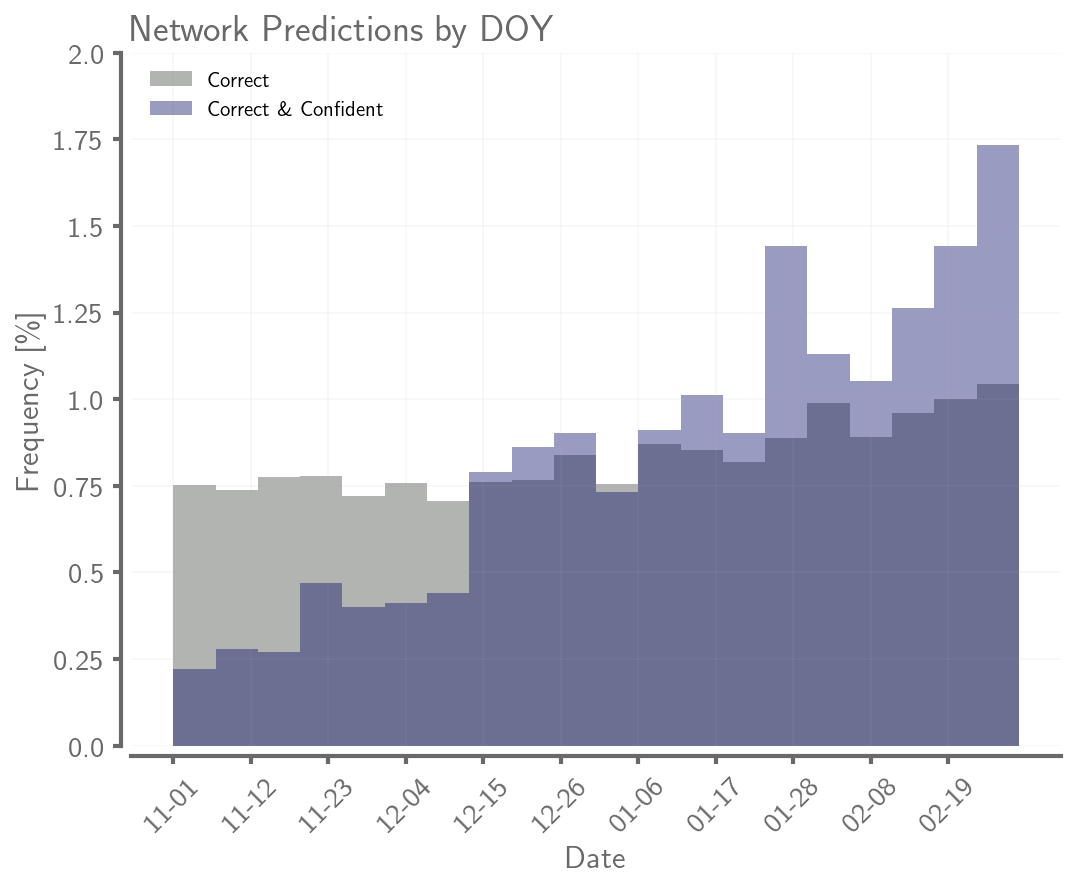

In [278]:
dtsdoing = pd.date_range(start='11-01-2000',end='02-28-2001')
labsy=[]
for dd in dtsdoing[np.arange(305,425,11)-305]:
    labsy.append(str(dd)[5:10])
fig = plt.figure(figsize=(8,6))
ax = fig.subplot_mosaic('''
                        A
                        ''') 
adjust_spines(ax['A'], ['left', 'bottom'])
ax['A'].spines['top'].set_color('none')
ax['A'].spines['right'].set_color('none')
ax['A'].spines['left'].set_color('dimgrey')
ax['A'].spines['bottom'].set_color('dimgrey')
ax['A'].spines['left'].set_linewidth(2)
ax['A'].spines['bottom'].set_linewidth(2)

plt.hist(rounded_ints[indx_corr],density=True,alpha=0.7,bins=20,color='xkcd:grey',label='Correct')
plt.hist(rounded_ints[indx_conf_corr],density=True,alpha=0.4,bins=20,color='xkcd:darkblue',label='Correct \& Confident')
plt.grid(True,alpha=0.1)

plt.title('Network Predictions by DOY',color='dimgrey',loc='left')
plt.legend(fontsize=10,frameon=False,loc='upper left')

current_yticks, current_yticklabels = plt.yticks()

ax['A'].set_ylabel('Frequency [\%]',color='dimgrey')
ax['A'].set_xlabel('Date',color='dimgrey')
ax['A'].tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax['A'].set_xticks(np.arange(305,425,11),labsy,rotation=45,fontsize=14,color='dimgrey')
ax['A'].set_yticks(current_yticks, np.round(current_yticks*100,2),fontsize=14,color='dimgrey')
# plt.savefig('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/plots/modelcontribution_main_final.png',dpi=300,bbox_inches='tight')
plt.show()



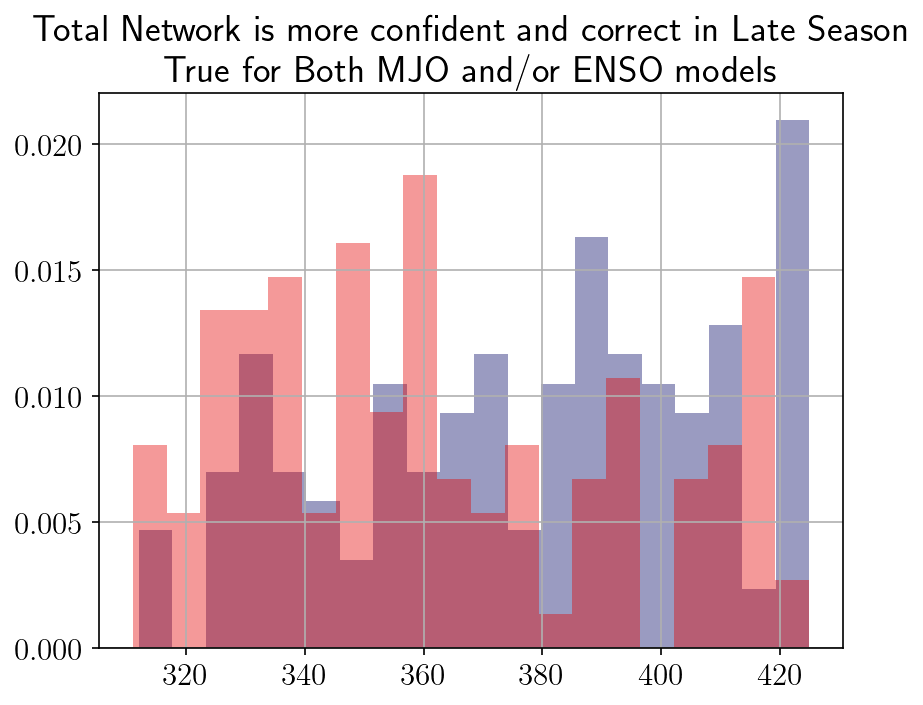

In [279]:
plt.hist(rounded_ints[i_conf_predval[i_model1_notmodel2_confcorr]],density=True,alpha=0.4,bins=20,color='xkcd:darkblue')
plt.hist(rounded_ints[i_conf_predval[i_model2_notmodel1_confcorr]],density=True,alpha=0.4,bins=20,color='xkcd:red')

# plt.hist(rounded_ints[indx_conf_corr_m1],density=True,alpha=0.4,bins=20,color='xkcd:teal')
# plt.hist(rounded_ints[indx_conf_corr_m2],density=True,alpha=0.4,bins=20,color='xkcd:teal')

# plt.hist(rounded_ints[indx_corr],density=True,alpha=0.7,bins=20,color='xkcd:grey')
plt.grid(True)
plt.title('Total Network is more confident and correct in Late Season\n True for Both MJO and/or ENSO models')
plt.show()

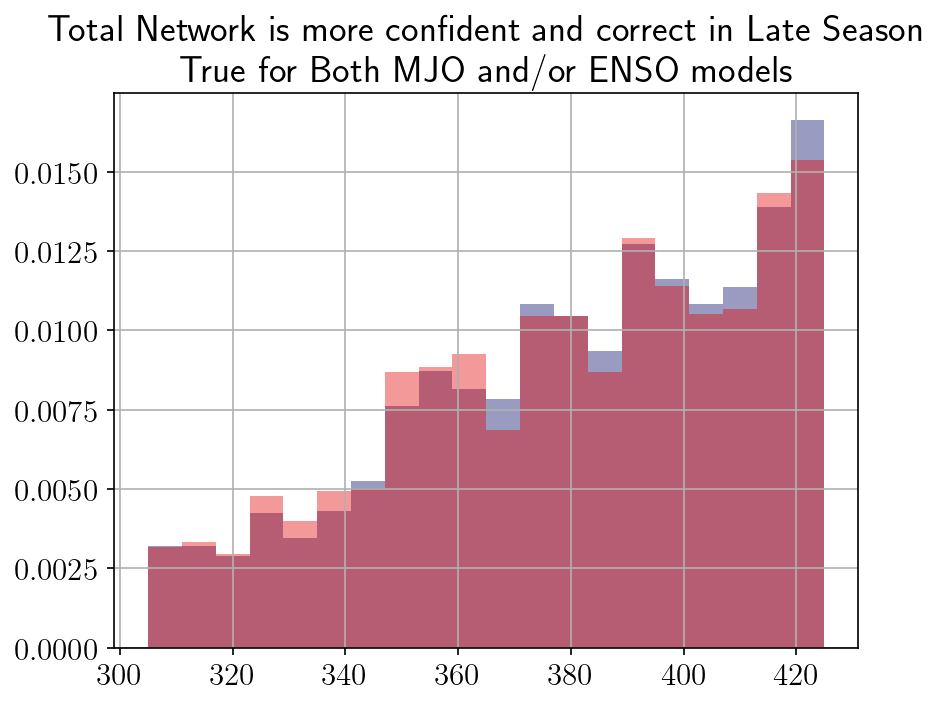

In [280]:
plt.hist(rounded_ints[i_conf_predval[i_model1only_confcorr]],density=True,alpha=0.4,bins=20,color='xkcd:darkblue')
plt.hist(rounded_ints[i_conf_predval[i_model2only_confcorr]],density=True,alpha=0.4,bins=20,color='xkcd:red')

# plt.hist(rounded_ints[indx_conf_corr_m1],density=True,alpha=0.4,bins=20,color='xkcd:teal')
# plt.hist(rounded_ints[indx_conf_corr_m2],density=True,alpha=0.4,bins=20,color='xkcd:teal')

# plt.hist(rounded_ints[indx_corr],density=True,alpha=0.7,bins=20,color='xkcd:grey')
plt.grid(True)
plt.title('Total Network is more confident and correct in Late Season\n True for Both MJO and/or ENSO models')
plt.show()